In [5]:
class Gibbs_free_energy:
    """Based on a predetermined bulk solution, this code can calculate the gibbs free energy of various reactions. Made by Dylan Verburg in april 2022"""
    def __init__(self, bulk_solution):
        import numpy as np
        import matplotlib.pyplot as plt
        import pandas as pd
        #bulk solution is denoted in pandas dataframe
        #entropies are based on the file below
        self.energies = pd.read_csv('entropy_enthalpy_table.csv', skiprows=[1], skipinitialspace=True, index_col=0)
        self.R = 8.314/1000 #kJ/mol K
        self.Ts = 298.15 #K
        self.bulk_solution = bulk_solution  #assume this to be a dataframe
    
### interface functions ###
    def read_reaction(self, reaction, undefined_concentrations, warnings = True):
        #undefined_concentrations = 1
        #initialize the lists
        stoichiometry = np.array([0])
        compound = np.array(['0'])
        concentration = np.array([0])
        gas = np.array([0])
        
        
        reaction_sides = reaction.split('-->') #split right and left hand side of equation
        
        for i in range(len(reaction_sides)): #this is for the two sides of the equation, but more would work aswell
            reaction_compounds = reaction_sides[i].split(' + ') #split compounds
            
            for j in range(len(reaction_compounds)):
                reaction_pure_compound = reaction_compounds[j].split('*') #see if there is one or more mole of the compound in the reaction
                
                if(len(reaction_pure_compound) == 1): #if there is nothing written in front of the material, assume it should be 1 and assume concentration to be 1
                    reaction_pure_compound = [1.0, reaction_compounds[j]]
               
                stoichiometry = np.append(stoichiometry, float(reaction_pure_compound[0]) * (-1.0)**(i + 1)) #make the stoichiometric variable positive or negative based on the side of the equation
                compound = np.append(compound, reaction_pure_compound[1].replace(" ", ""))
                
                gas = np.append(gas, reaction_pure_compound[1].find("(g)") <= 0) #is this a gas or not
                #add a concentration provided in the bulk, and prevent errors if it is not provided
                try:
                    concentration = np.append(concentration, self.bulk_solution.loc[compound[-1]])
                except:
                    concentration = np.append(concentration, undefined_concentrations)
                    if warnings == True:
                        print(f'No concentration for {reaction_pure_compound[1]} was found. It was set to {undefined_concentrations}')
                
        #put everything in a pandas dataframe for easier lookup accros tables
        reaction_full = pd.DataFrame(list(zip(stoichiometry, concentration)), index = compound, columns = ['Stoichiometry','Concentration'], dtype = float)
        
        reaction_full["Gas"] = gas
        reaction_full = reaction_full.drop('0')
        
        return reaction_full
    
    def check_reaction(self, reaction):
        #This function checks if the provided reactions are balanced
        reaction_matrix = self.read_reaction(reaction, 1, warnings = False)
        #define some lists and the list to work on
        compound_list = []
        value_list = []
        
        #iterate through the compounds in the reaction, drop the phase and the charge of these aswell
        for compound in range(len(reaction_matrix)):
            find = reaction_matrix.index[compound]  
            #drop phase
            b = find.find('(')
            text = find[0:b]
            
            #drop charge and find ion balance, also for multivalent ions
            if text.find('-') > 0 or text.find('+') > 0:
                
                char_sym_ind = max(text.find('-'), text.find('+'))

                charge = text[char_sym_ind:]
                #count the charge balance contribution
                name = 'e'
                try: 
                    e = float(charge[1]) * reaction_matrix.Stoichiometry[compound]
                except: 
                    e = reaction_matrix.Stoichiometry[compound]
                
                #this allows 2*O2- + 4* H+ --> 2* H2O to have balanced charges
                if(charge[0] == '-'):
                    e *= -1
                compound_list.append(name) 
                value_list.append(e)
                
                #scrub the charge for further analysis
                text = text[0:char_sym_ind]
                
            #this takes the scrubbed compounds and finds the capital letters, this allows for simple compounds like 'H', for hydrogen, but also 'Ca' for calcium to be balanced
            d = ''.join(' ' + char if char.isupper() else char.strip() for char in text).strip().split(" ")
            #iterate through all these parts of a compound, some like CO2 have no number next to the C, 
            #the try, except structure, deals with this and appends the stoichiometric value of a compound to a list, as well as the compound itself
            for i in range(len(d)):
                try: 
                    e = float(d[i][-1]) * reaction_matrix.Stoichiometry[compound]
                    name = d[i][0:-1]
                except: 
                    e = reaction_matrix.Stoichiometry[compound]
                    name = d[i][:]
                compound_list.append(name) 
                value_list.append(e)
                
        #once all compounds have been added, the unique compounds are put in a list to which a parralel list for bookkeeping is made
        unique = list(set(compound_list))
        values_unique = [0] * len(unique)

        #find the index of the compound in the unique list, add the stoichiometry to the values list
        for p in range(len(compound_list)):
            index = unique.index(compound_list[p])
            values_unique[index] += value_list[p]
        
        #find all non_zero values in the list, these are thus not balanced
        missing_index = np.nonzero(values_unique)[0]
        
        #give human readable output for both the case of balance, and impabalnce
        if len(missing_index) > 0:
            print(f'Non balanced reaction {reaction} ,is missing:')
            for i in range(len(missing_index)):
                print(f'{values_unique[missing_index[i]]} {unique[missing_index[i]]}')
        else: print('Balanced reaction')
        
### Thermodynamic functions ###
    def define_G(self, reaction_matrix):
        
        #This function gives the initial G and H values
        #initialize
        dH = 0
        dG = 0
        
        #find in provided matrix of gibbs energies
        for i in range(len(reaction_matrix)):
            Gibbs_values = self.energies.loc[reaction_matrix.index[i], :] #find the dH and dS values
            
            #combine the energies to gain a reaction energy
            dH += reaction_matrix.Stoichiometry[i] * float(Gibbs_values[0])
            dG += reaction_matrix.Stoichiometry[i] * float(Gibbs_values[2])   
            #print(dG, dH)
        return dG, dH
    
    def T_C_comp_linear(self, reaction_matrix, d_G0S, d_H0S, T):
        #T compensation for a range of T in K, as well as concentration compensation based on the bulk solution and gasses       
        #concentration compensation for gasses and non-gasses on the same range of T        
        reaction_matrix["mult"] = reaction_matrix.Stoichiometry * np.log(reaction_matrix.Concentration) 
        
        non_gasses = reaction_matrix.mult[reaction_matrix.Gas > 0].sum(axis=0)
        gasses = reaction_matrix.mult[reaction_matrix.Gas == 0].sum(axis=0) 
        
        #gasses should be in b but that doesn't seem to work
        #This is based on shuffeling the Gibbs free energy calculation into making it a linear function in T, provided the concentrations do not change
        a = self.R * (gasses + non_gasses) + (d_G0S - d_H0S) / self.Ts
        b =  d_H0S #+ gasses
        
        # coeficients for certain concentrations, this makes simulating a temprature range more memory efficient
        return a , b

    def give_for_T(self, reaction, T = [-1], undefined_concentrations = 1, warnings = True):
        #allows the user to ask for the gibbs energy at a certain temprature, or range of tempratures
        reaction_matrix = self.read_reaction(reaction, undefined_concentrations, warnings)
        
        #provides easy way to provide dG for standard temprature (298.15K), just used for easy interaction
        if(T[-1]<0):
            T = self.Ts
        
        #find the standard T, G and H values
        dG, dH = self.define_G(reaction_matrix)
        #feed these to the T and concentration compensation function
        a, b = self.T_C_comp_linear(reaction_matrix, dG, dH, T)
        #create the array based on the temprature fed into the function
        dGT = a * np.array(T) + b
        return dGT
    
    def thin_film(self, reaction_matrix, T, C_diff = 0.1, steps = 11):
        #Basic code to resemble difussion driven change in substrate and products by changing the concentration over time  
        a_row = []
        b_row = []
        c_row = []
        concentration_row = []
        
        Concentrations= reaction_matrix.Concentration.tolist()
        #molar difference based on a percentage of the first compound
        diff = (reaction_matrix.Concentration.iloc[0] * C_diff / reaction_matrix.Stoichiometry[0]) * reaction_matrix.Stoichiometry
        concentration_row.append(Concentrations)
        
        d_G0s, d_H0s = self.define_G(reaction_matrix)
  
        for i in range(steps):
            a, b = self.T_C_comp_linear(reaction_matrix, d_G0s, d_H0s, T)
            
            a_row.append(a)
            b_row.append(b)
            c_row.append(round(C_diff * i, 3))
            
            #change the concentration of reaction products and substrates, the idea is to decrease the concentration with 10% (C_diff) per step (steps) for the whole reaction, thus stoichiometry plays a role
            Concentrations -= diff
            #prevent negative concentrations
            Concentrations[Concentrations < 0] = 1e-11
            
            concentration_row.append(Concentrations.tolist())
            reaction_matrix.Concentration = Concentrations
            
        return np.array(a_row), np.array(b_row), np.array(c_row), concentration_row

### Visual functions ###    
    def plot_for_T(self, reaction, Tmin = 0, Tmax = 500, undefined_concentrations = 1, warnings = True, title = ""):
        T = np.linspace(Tmin, Tmax, 50)
        dGT = self.give_for_T(reaction, T, undefined_concentrations, warnings)
        
        if title == "":
            title = reaction
        
        #plt.figure()
        plt.title(f'Gibbs free energy for {title}.')
        #plt.plot((T[0], T[-1]),(-20, -20), label = 'low energy quantum -20 kJ/mol') #based on Müller et al 2017, less is possible, but no figure is given for this.
        plt.plot(T, dGT, label = f"{title}")
        plt.ylabel("Gibbs free energy of reaction [kJ/Mol]")
        plt.xlabel("Temprature [K]")
        #plt.legend()
            
    def thin_film_simulation(self, reaction, Tmin = 0, Tmax = 500, C_diff = 0.1, steps = 11, undefined_concentrations = 1, warnings = True, title = "", show = "show"):
        """show: table, save, show, d_out. respectavily for generating a table for use in LaTeX, saving the plots, only showing everything on screen and outputing dG_t for the given T range and C diff steps"""
        
        T = np.linspace(Tmin, Tmax, 50)
        reaction_matrix = self.read_reaction(reaction, undefined_concentrations, warnings = warnings)
        a, b, sim_range, concentration_row = self.thin_film(reaction_matrix, T, C_diff, steps)
        
        dGT= []
        for i in range(len(a)):
            dGT.append(a[i] * T + b[i])
                   
        if title == "":
            title = "thin film" + reaction        
        
        if show == "d_out":
            return dGT
            
        if show == "save": 
            plt.figure()
            plt.title(f'Gibbs free energy for {title}.')
            plt.plot((T[0], T[-1]),(-20, -20), label = 'low energy quantum -20 kJ/mol') #based on Müller et al 2017, less is possible, but no figure is given for this.

            for i in range(len(sim_range)):
                plt.plot(T, dGT[i], label = f'{sim_range[i] * 100}% reduction of the first compound.')

            plt.ylabel("Gibbs free energy of reaction [kJ/Mol]")
            plt.xlabel("Temprature [K]")
            #plt.legend()
        
            print(f'For {reaction}:')
            plt.savefig(f'GFE_C_range_{title}.png')
            
            
        if show == "show":
            plt.figure()
            plt.title(f'Gibbs free energy for {title}.')
            plt.plot((T[0], T[-1]),(-20, -20), label = 'low energy quantum -20 kJ/mol') #based on Müller et al 2017, less is possible, but no figure is given for this.

            for i in range(len(sim_range)):
                plt.plot(T, dGT[i], label = f'{sim_range[i] * 100}% reduction of the first compound.')

            plt.ylabel("Gibbs free energy of reaction [kJ/Mol]")
            plt.xlabel("Temprature [K]")
            #plt.legend()
        
            print(f'For {reaction}:')
            plt.show()
            
            print(f"Concentration" , end = '\t')
            print(*list(reaction_matrix.index.values), sep = '\t\t', end = '\t')
            print("Gibbs(T) ")
            
            for i in range(steps):
                print({sim_range[i]}, end = '\t')
                print(*('{:.3e}'.format(x) for x in concentration_row[i]), sep='\t', end = '\t')
                print("{:.3e}".format(a[i]), '* T +', "{:.3e}".format(b[i]))
        
        if show == 'table': #method to generate LaTeX tables form the raw data, to aid the writing process
            print('\\begin{table}[h!]')
            print('\\caption {Exact output for ', end = '')
            print(title, end = '')
            print(', figure: \\ref{fig:GFE_C_range_', end = '')
            print(title, end = '')
            print('}}')
            print('\\label{tab:GFE_C_range_', end = '')
            print( title, end = '')
            print( '}')
            print('\\begin{tabular}{', end = '')
            print((len(reaction_matrix) + 2) * "l", end = '' )
            print( '}')
            print('\\multicolumn{', end = '' )
            print((len(reaction_matrix) + 2), end = '' )
            print('}{l}{For ' , end = '' )
            print(reaction, end = '' )
            print(" :} \\\\")
            #table header
            print(f"Conc. red. [-]" , end = '&')
            print(*list(reaction_matrix.index.values), sep = '&', end = '&')
            print("Gibbs(T)\\\\")
            
            
            for i in range(steps):    
                print(sim_range[i] , end = '&')      
                print(*('{:.3e}'.format(x) for x in concentration_row[i]), sep='&', end = '&')
                print("{:.3e}".format(a[i]), '* T +', "{:.3e}".format(b[i]), '\\\\')
            print("\end{tabular}")
            print("\end{table}")
            print("")

In [8]:
#define bulk solution based on expirimental P-MRA version
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
        
bulk_MRA = np.array([["CO2(g)", 0.951],
                ['N2(g)', 0.0259],
                ['Ar(g)', 0.0194],
                ['O2(g)', 0.0016],
                ['CO(g)', 0.0006],
                ['H2(g)', 1e-7],
                ['CH4(g)', 1e-7], #pP
                ['H2O(l)', 1000],
                ["SiO2", 3.00018], #g/L
                ["MgSiO4", 2.000123084],
                ["FeSiO4", 4.61892831],
                ["Fe2O3", 4.61892831],
                ["(Na,Ca)0.33(Al,Mg)2(Si4O10)(OH)2·nH2O", 45.0027694],
                ["Al2Si2O5(OH)4", 6.366917234],
                ["FeCO3", 11.14475363],
                ["Mg5(CO3)4(OH)2*4H2O", 5.000307711],
                ["NO3-", 0.060003693],
                ["C2H3O2-", 1.600098468],
                ])

#list based on Kurth et al. 2020 for the methanogenic reactions
#compounds to be seperated by ' + ', this prevents problems with positively charged compounds. 
reactions = ['4.0 * H2(g) + CO2(g) --> CH4(g) + 2.0 * H2O(l)', 
            '4*HCO2-(aq) + 4*H+(aq) --> CH4(g) + 3*CO2(g) + 2*H2O(l)',
            'CH3OH(l) + H2(g) --> CH4(g) + H2O(l)',    #CH3OH boils at 64.7C / 337K
            '4*CH3OH(l) --> CO2(g) + 3*CH4(g) + 2*H2O(l)',
            'CH3COOH(l) --> CO2(g) + CH4(g)',  
            '4* CO2(g) + 8* H2(g) -->4* H2O(l) + 2* CH3COOH(l)',
            'SO4-2(aq) + 2 * CH2O(aq) --> H2S(g) + 2*HCO3-(aq)',
            '5 * H2(g) + SO4-2(aq) --> H2S(g) + 4 * H2O(l)'
           ]

titles = [ "Hydrogenotrophic methanogenesis",
           "Formate based methylotrophic methanogenesis",
           "Hydrogen based methylotrophic methanogenesis",
           "Methylotrophic methanogenesis",
           "Aceticlastic methanogenesis",
           "Homoacetogenesis",
           'Formaldyhyde based sulphate reduction to sulphur gas',
           'Hydrogenotrophic sulfate reducers'
        ]

#this line can be used for more complex bulk solutions, that are formated in csv from for example PHREEQC
#bulk_MRA = pd.read_csv('bulk_solution.csv', index_col = 'material')

#this line allows the above definition to be used in the class
bulk_MRA = pd.DataFrame(bulk_MRA[:,1], index = bulk_MRA[:,0], columns = ['concentration'])

#create an instance of the gibbs free energy class, in this enviroment multiple reactions can be explored.
MRA = Gibbs_free_energy(bulk_MRA)

For 4.0 * H2(g) + CO2(g) --> CH4(g) + 2.0 * H2O(l):
For 4*HCO2-(aq) + 4*H+(aq) --> CH4(g) + 3*CO2(g) + 2*H2O(l):
For CH3OH(l) + H2(g) --> CH4(g) + H2O(l):
For 4*CH3OH(l) --> CO2(g) + 3*CH4(g) + 2*H2O(l):
For CH3COOH(l) --> CO2(g) + CH4(g):
For 4* CO2(g) + 8* H2(g) -->4* H2O(l) + 2* CH3COOH(l):
For SO4-2(aq) + 2 * CH2O(aq) --> H2S(g) + 2*HCO3-(aq):
For 5 * H2(g) + SO4-2(aq) --> H2S(g) + 4 * H2O(l):


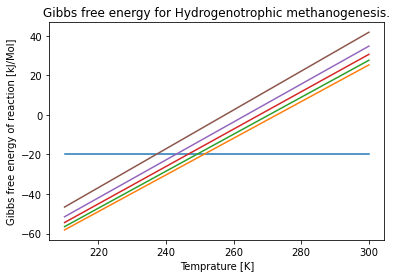

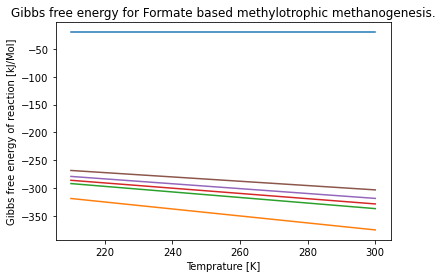

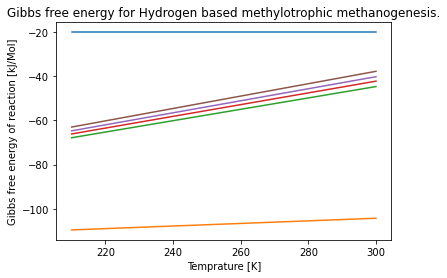

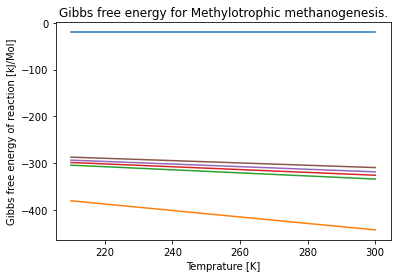

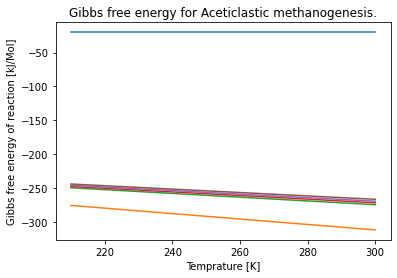

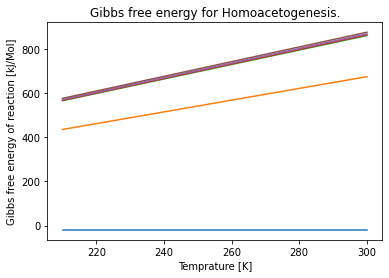

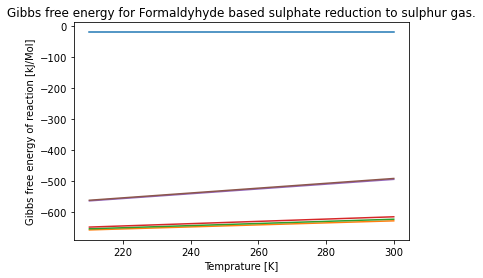

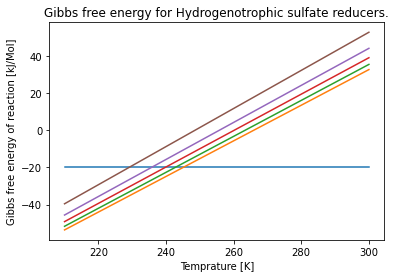

In [9]:
#example calculations

for i in range(len(reactions)):
    #MRA.check_reaction(reactions[i])
    MRA.thin_film_simulation(reactions[i], title = titles[i], steps = 5, C_diff = 0.2, Tmin = 210, Tmax = 300, warnings = False, show = 'save' )
    #MRA.plot_for_T(reactions[i], title = titles[i], Tmin = 210, Tmax = 300)
    
#plt.legend(loc = "center left")
#MRA.check_reaction(reactions[0])
#MRA.give_for_T(reaction, T = [308.15])

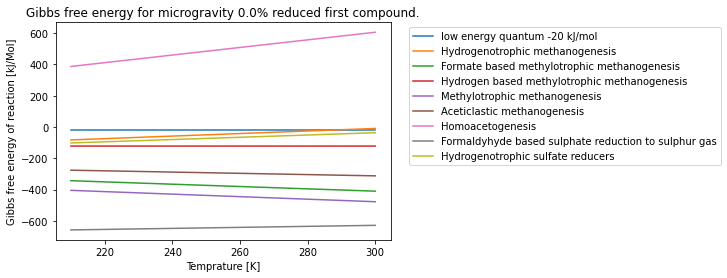

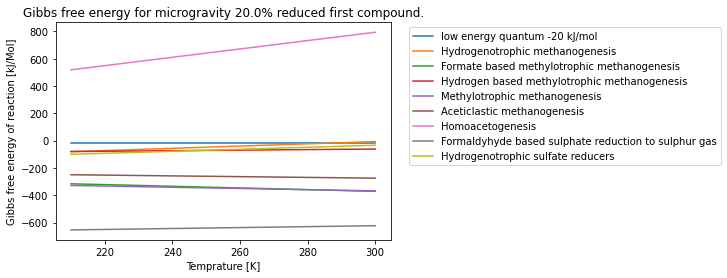

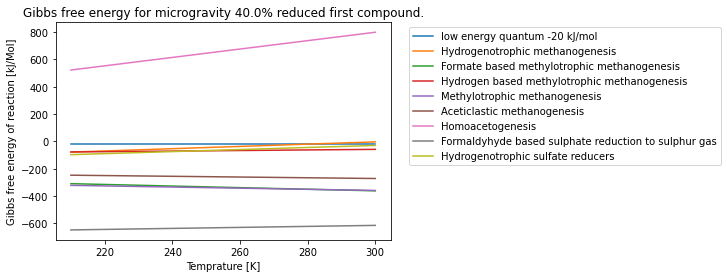

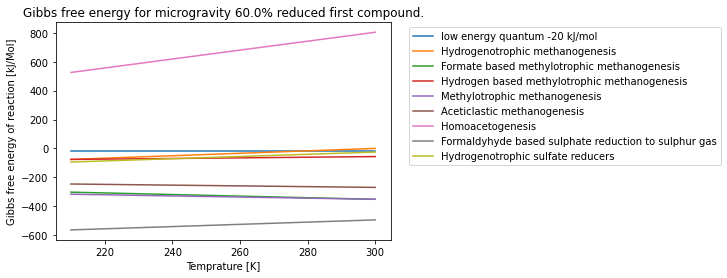

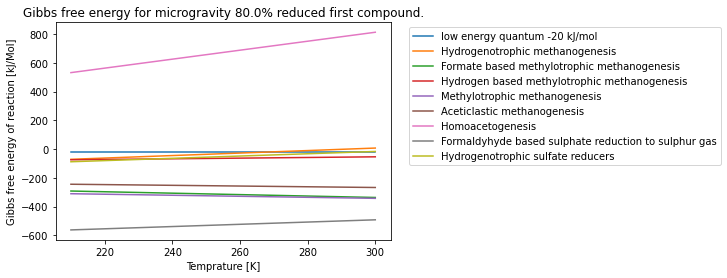

In [4]:
#for plotting microgravity effects
T_min = 210
T_max = 300
steps = 5
dGt_T = np.zeros([len(reactions), 5, 50])


for i in range(len(reactions)):
    dGt_T[i] =  MRA.thin_film_simulation(reactions[i], title = titles[i], steps = steps, C_diff = 0.2, Tmin = T_min, Tmax = T_max, warnings = False, show = 'd_out' )

T = np.linspace(T_min, T_max, np.shape(dGt_T)[-1])


for y in range(steps):
    plt.figure()
    plt.title(f'Gibbs free energy for microgravity {y/0.05}% reduced first compound.')
    plt.plot((T[0], T[-1]),(-20, -20), label = 'low energy quantum -20 kJ/mol') #based on Müller et al 2017, less is possible, but no figure is given for this.

    for i in range(len(reactions)):
        plt.plot(T, dGt_T[i, y, :], label = titles[i])
    
    plt.ylabel("Gibbs free energy of reaction [kJ/Mol]")
    plt.xlabel("Temprature [K]")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.savefig(f'GFE_C_range_uG_{y/0.05}_leg.png')